# DCGAN
stands for Deep Covolutional Generative Adversarial Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## Data preprocess

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [ ]:
train_x = (train_x - 127.5) / 127.5
test_x = (test_x - 127.5) / 127.5

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1).astype('float32')

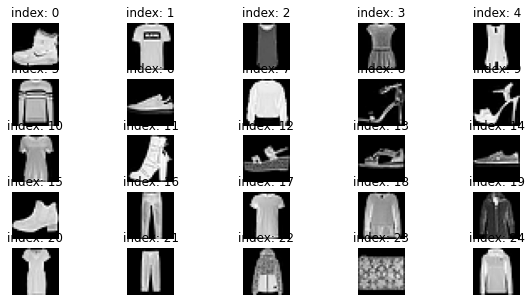

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

## Model construction

### Generator

In [ ]:
def make_generator_model(): # z -> image(decoding)

    model = tf.keras.Sequential()

    # 1st: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2nd: Reshaping layer
    model.add(layers.Reshape((7, 7, 256))) #3d

    # 3rd: Conv2D Transposed layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4th: Conv2D Transposed layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5th: Conv2D Transposed layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, 
                                     activation='tanh'))
    
    return model    

In [ ]:
G = make_generator_model()

G.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
noise.shape

TensorShape([1, 100])

In [ ]:
gen_image = G(noise, training=False)
gen_image.shape

TensorShape([1, 28, 28, 1])

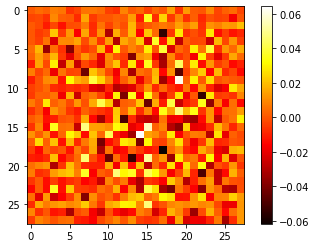

In [ ]:
plt.imshow(gen_image[0, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

### Discriminator

In [ ]:
def make_discriminator_model(): # backbone 

    model = tf.keras.Sequential()

    # 1st: Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # 2nd: Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # 3rd: Flatten layer
    model.add(layers.Flatten())

    # 4th: Dense layer
    model.add(layers.Dense(1))

    return model

In [ ]:
D = make_discriminator_model()
D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
decision = D(gen_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00123369]], dtype=float32)>

In [ ]:
#logits=True: loss를 [0, 1]로 scaling하기 위함
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

### Loss
- Generator의 입장에서 `fake_output`이 1(`True`)에 가깝도록
- Discriminator의 입장에서
    - `real_output`은 1에 가깝게,
    - `fake_output`은 0(`False`)에 가깝게 학습하는 것이 바람직함
    - 두 loss를 더한 값을 `D_loss`로 저장


In [ ]:
def G_loss(fake_output):
     return cross_entropy(tf.ones_like(fake_output), fake_output)


def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### Accuracy
- if `real_accuracy`
    - `== 0`: Discriminator 성능 부족
    - `== 1`: Generator 성능 부족

`real_accuracy == fake_accuracy == 0.5`: 이 경우, Discriminator가 진위여부를 운에 맡기므로, 성능 최고

In [ ]:
def D_acc(real_output, fake_output):
    real_acc = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_acc, fake_acc

### Optimizer

In [ ]:
lr = 1e-4

In [ ]:
G_optim = tf.keras.optimizers.Adam(lr)
D_optim = tf.keras.optimizers.Adam(lr)

### Train step function
Decorator `@tf.function`활요

In [ ]:
@tf.function
def train_step(images, BATCH_SIZE=BATCH_SIZE, noise_dim=noise_dim): # 입력 데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])   # Generator 입력 노이즈

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape: # tf.GradientTape()
        gen_images = G(noise, training=True) # gen_image 생성

        # Discriminator 판별 과정
        real_output = D(images, training=True)   
        fake_output = D(gen_images)

        # Loss 계산
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)

        # Accuracy 계산
        real_acc, fake_acc = D_acc(real_output, fake_output)

    # Gradient 계산
    G_grad = G_tape.gradient(gen_loss, G.trainable_variables)
    D_grad = D_tape.gradient(disc_loss, D.trainable_variables)

    # 모델 학습
    G_optim.apply_gradients(zip(G_grad, G.trainable_variables))
    D_optim.apply_gradients(zip(D_grad, D.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

### 학습 관찰 샘플 함수

In [ ]:
def gen_and_save_img(model, epoch, iter, sample_seeds):

    pred = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred[i, :, :, 0], cmap='hot')
        plt.axis("off")

    plt.savefig('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, iter))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # Matlab 차트의 기본 크기를 15, 6으로 지정

def draw_train_history(history, epoch):
    # Loss history를 요약
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper_left')

    # Accuracy history 요약
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    # training_history 디렉토리에 epoch별 그래프를 gif 형태로 저장
    plt.savefig('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

### Checkpoint 선언

In [ ]:
ckpt_dir = '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/training_checkpoints'

ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
ckpt = tf.train.Checkpoint(generator_optimizer=G_optim,
                           discriminator_optimizer=D_optim,
                           generator=G,
                           discriminator=D)

### 학습 함수

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for iter, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if iter % 50 == 0:
                display.clear_output(wait=True)
                gen_and_save_img(G, epoch + 1, iter + 1, seed)
                print('Epoch {} | iter {}'.format(epoch + 1, iter + 1))
                print('Time for epoch {} : {} sec'.format(epoch + 1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            ckpt.save(file_prefix=ckpt_prefix)

        display.clear_output(wait=True)
        gen_and_save_img(G, epochs, iter, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)        

In [ ]:
save_every = 5
EPOCHS = 50

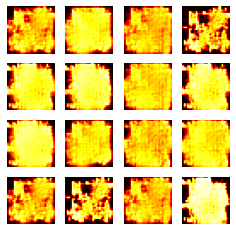

Time for training : 468 sec


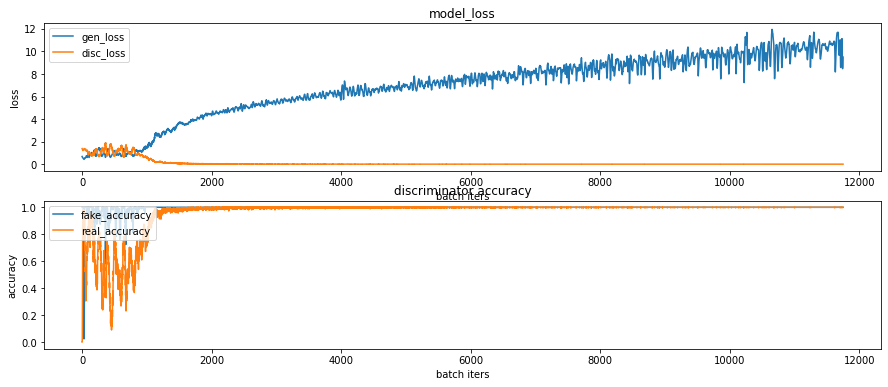

CPU times: user 4min 40s, sys: 8.32 s, total: 4min 49s
Wall time: 7min 49s


In [ ]:
%%time
train(train_ds, EPOCHS, save_every)